# Discover the Higgs with Deep Neural Networks

The input data was created from 13 TeV ATLAS open data downloaded from http://opendata.atlas.cern/release/2020/documentation/index.html

For more information read:<br>
Review of the 13 TeV ATLAS Open Data release, Techn. Ber., All figures including auxiliary figures are available at https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-OREACH-PUB-2020-001: CERN, 2020, url: http://cds.cern.ch/record/2707171

## Data Preparation

### Load the Data

In [ ]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
import common

The goal of this lab course is to train a deep neural network to separate Higgs boson signal from background events. The most important signal sample ggH125_ZZ4lep corresponds to the process gg->H->ZZ. The dominant background sample is llll resulting from Z and ZZ decays.
After training the DNN model will be used to classify the events of the data samples.

Higgs signal samples:
- ggH125_ZZ4lep
- VBFH125_ZZ4lep
- WH125_ZZ4lep
- ZH125_ZZ4lep

Background samples:
- llll
- Zee
- Zmumu
- ttbar_lep

Data samples:
- data_A
- data_B
- data_C
- data_D

In [ ]:
# Define the input samples
sample_list_signal = ['ggH125_ZZ4lep']
sample_list_background = ['llll']
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']

In [ ]:
# Read all the samples
no_selection_data_frames = {}
for sample in sample_list_signal + sample_list_background:
    no_selection_data_frames[sample] = pd.read_csv('input/' + sample + ".csv")

### Input Variables

The input provides several variables to classify the events. Since each event has multiple leptons, they were ordered in descending order based on their transverse momentum. Thus, lepton 1 has the highest transverse momentum, lepton 2 the second highest, and so on. <br>
Most of the given variables can be called low-level, because they represent event or object properties, which can be derived directly from the reconstruction in the detector. In contrast to this are high-level variables, which result from the combination of several low-level variables. In the given dataset the only high-level variables are invariant masses of multiple particles:<br>
$m_{inv} = \sqrt{\left(\sum\limits_{i=1}^{n} E_i\right)^2 - \left(\sum\limits_{i=1}^{n} \vec{p}_i\right)^2}$


List of all available variables:<br>
- Event number
 - Each simulated event has its own specific number. (not used for training)
 - Variable name: eventNumber
- Scale and event weight
 - The scaling for a data set is given by the sum of event weights, the cross section, luminosity and a efficiency scale factor
 - Each event has an additional specific event weight
 - To combine simulated events and finally compare them to data each event has to be scaled by the total weight, the product of scale weight and event weight
 - The weight are not used for training
 - Variable name: scaleWeight, eventWeight, totalWeight
- Number of jets
 - Jets are particle showers which result primarily from quarks and gluons
 - Variable name: jet_n
- Invariant four lepton mass
 - The invariant mass $m_{inv}(l_1, l_2, l_3, l_4)$ of the four leptons is extremly sensitive to Higgs boson events. This variable is to be displayed later and thus not used for training
 - Variable name: lep_m_llll
- Invariant two lepton mass
 - Invariant masses $m_{inv}(l_i, l_j)$ of all combinations of two leptons
 - Variable names: lep_m_ll_12, lep_m_ll_13, lep_m_ll_14, lep_m_ll_23, lep_m_ll_24, lep_m_ll_34
- Transverse momentum of the leptons
 - The momentum in the plane transverse to the beam axis
 - Variable names: lep1_pt, lep2_pt, lep3_pt, lep4_pt
- Lepton azimuthal angle
 - The azimuthal angle $\phi$ is measured in the plane transverse to the beam axis
 - Variable name: lep1_phi, lep2_phi, lep3_phi, lep4_phi
- Lepton pseudo rapidity
 - The angle $\theta$ is measured between the lepton track and the beam axis. Since this angle is not invariant against boosts along the beam axis, the pseudo rapidity $\eta = - \ln{\tan{\frac{\theta}{2}}}$ is primarily used in the ATLAS analyses
 - Variable names: lep1_eta, lep2_eta, lep3_eta, lep4_eta
- Lepton energy
 - The energy of the leptons reconstructed from the calorimeter entries
 - Variable name:lep1_e, lep2_e, lep3_e, lep4_e
- Lepton PDG-ID
 - The lepton type is classified by a n umber given by the Particle-Data-Group. The lepton types are $pdg-id(e)=11$, $pdg-id(\mu)=13$ and $pdg-id(\tau)=15$
 - Variable name: lep1_pdgId, lep2_pdgId, lep3_pdgId, lep4_pdgId
- Lepton charge
 - The charge of the given lepton reconstructed by the lepton track
 - Variable name: lep1_charge, lep2_charge, lep3_charge, lep4_charge

### Event Pre-Selection

Although the final selection of the data is to be performed on the basis of a DNN, a rough pre-selection of the data is still useful.
For this purpose, selection criteria are defined, which return either true or false based on the event kinematics and thus decide whether the respective event is kept or discarded.
Suitable criteria for this analysis are very basic selections that must be clearly fulfilled by H->ZZ->llll processes.


Hint: What lepton types and charges are expected in the final state?

In [ ]:
def cut_lep_type(lep_type_0, lep_type_1, lep_type_2, lep_type_3):
    # Only keep events like eeee, mumumumu or eemumu
    sum_lep_type = lep_type_0 + lep_type_1 + lep_type_2 + lep_type_3
    return sum_lep_type == 44 or sum_lep_type == 48 or sum_lep_type == 52


def cut_lep_charge(lep_charge_0, lep_charge_1, lep_charge_2, lep_charge_3):
    # Only keep events where the sum of all lepton charges is zero
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    return sum_lep_charge == 0

In [ ]:
# Create a copy of the original data frame to investigate later
data_frames = no_selection_data_frames.copy()

# Apply the chosen selection criteria
for sample in sample_list_signal + sample_list_background:
    # Selection on lepton type
    type_selection = np.vectorize(cut_lep_type)(
        data_frames[sample].lep1_pdgId,
        data_frames[sample].lep2_pdgId,
        data_frames[sample].lep3_pdgId,
        data_frames[sample].lep4_pdgId)
    data_frames[sample] = data_frames[sample][type_selection]

    # Selection on lepton charge
    charge_selection = np.vectorize(cut_lep_charge)(
        data_frames[sample].lep1_charge,
        data_frames[sample].lep2_charge,
        data_frames[sample].lep3_charge,
        data_frames[sample].lep4_charge)
    data_frames[sample] = data_frames[sample][charge_selection]

### Data Investigation

Before one can decide which variables are suitable for training, one must first get a feel for the input variables.
For this purpose, the input samples are merged into a set of signal events and a set of background events. Afterwards, the behavior of signal and background can be studied in multiple variables.

In [ ]:
# Merge the signal and background data frames
def merge_data_frames(sample_list, data_frames_dic):
    for sample in sample_list:
        if sample == sample_list[0]:
            output_data_frame = data_frames_dic[sample]
        else:
            output_data_frame = pd.concat([output_data_frame, data_frames_dic[sample]], axis=0)
        print(f'{sample}:')
        n_events = sum(data_frames_dic[sample]['totalWeight'])
        n_events_raw = len(data_frames_dic[sample]['totalWeight'])
        n_events_neg = sum(data_frames_dic[sample]['totalWeight'] * (data_frames_dic[sample]['totalWeight'] < 0))
        n_events_neg_raw = sum(list(data_frames_dic[sample]['totalWeight'] < 0))
        print(f'Total number of events: {round(n_events, 2)}')
        print(f'Negative raw events: {round(100 * n_events_neg_raw / n_events_raw, 2)}%')
        print(f'Negative events: {abs(round(100 * n_events_neg / n_events, 2))}%')
        print()
    return output_data_frame

data_frame_signal = merge_data_frames(sample_list_signal, data_frames)
data_frame_background = merge_data_frames(sample_list_background, data_frames)

The function common.plot_hist(variable, data_frame_1, data_frame_2) plots the given variable of the two data sets.
The variable must be a dictionary containing atleast the variable to plot. Additionally one can also specify the binning (list or numpy array) and the xlabel. The created histogram is automatically saved in the plots directory<br>
An example for the transverse momnetum of the leading lepton is given below:

In [ ]:
# leading lepton pt
var_lep1_pt = {'variable': 'lep1_pt',
               'binning': np.linspace(0, 300, 100),
               'xlabel': '$p_T$ (lep 1) [GeV]'}

common.plot_hist_sum(var_lep1_pt, data_frames)
common.plot_normed_signal_vs_background(var_lep1_pt, data_frame_signal, data_frame_background)

Investigate the signal vs background ratio before the training

In [ ]:
signal_event_number = sum(data_frame_signal.totalWeight)
background_event_number = sum(data_frame_background.totalWeight)
signal_background_ratio = signal_event_number/background_event_number
print(f'There are {round(signal_event_number, 2)} signal ({len(data_frame_signal)} raw MC events) and {round(background_event_number, 2)} backgound events ({len(data_frame_background)} raw MC events)\nThis gives a purity of {round(signal_background_ratio*100, 2)}%')

## Training

In this chapter, the DNN is trained. Define the input variables for the classification. Feel free to test different combinations of low-level and high-level variables. Additionally, you can modify the structure of the DNN to gain optimal training results. When the setup is done, train the DNN, test it and redo this until you are happy with the result.

In [ ]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
training_variables += ['lep1_charge', 'lep2_charge', 'lep3_charge', 'lep4_charge']
training_variables += ['lep1_pdgId', 'lep2_pdgId', 'lep3_pdgId', 'lep4_pdgId']
training_variables += ['lep1_phi', 'lep2_phi', 'lep3_phi', 'lep4_phi']
training_variables += ['lep1_eta', 'lep2_eta', 'lep3_eta', 'lep4_eta']
training_variables += ['lep_m_ll_12', 'lep_m_ll_13', 'lep_m_ll_14', 'lep_m_ll_23', 'lep_m_ll_24', 'lep_m_ll_34']

In [ ]:
# Create the training input
values = []
weights = []
classification = []
for sample in sample_list_signal + sample_list_background:
    # Classify signal and background (and skip if data)
    if sample in sample_list_signal:
        # 1 if signal
        classification.append(np.ones(len(data_frames[sample])))
    elif sample in sample_list_background:
        # 0 if background
        classification.append(np.zeros(len(data_frames[sample])))
    else:
        continue
    # input values
    values.append(data_frames[sample][training_variables])
    weights.append(data_frames[sample]['totalWeight'])

# Merge the input
values = np.concatenate(values)
weights = np.concatenate(weights)
classification = np.concatenate(classification)

The data set is split in a training, test and validation set. To have enough data to train use a splitting of 80%:10%:10%

In [ ]:
from sklearn.model_selection import train_test_split

Rescale the weights and keep the sample ratio?

In [72]:
def reweight_weights(weights, classification):
    # Take the absolute weight
    weights_abs = np.abs(weights)
    # Split in signal and background weights
    weights_signal = weights_abs*classification
    weights_background = weights_abs*(1 - classification)
    # Set ratio of signal and backgroubnd to one
    weights_reweighted = weights_background / sum(weights_background) + weights_signal / sum(weights_signal)
    # Normalize mean weight to one
    weights_reweighted /= weights_reweighted.mean()
    print(weights_reweighted.mean())
    return weights_reweighted

In [73]:
random_state = 420

# Train data
train_values, test_val_values, train_classification, test_val_classification = train_test_split(values, classification, test_size=0.2, random_state=random_state)
train_weights, test_val_weights = train_test_split(weights, classification, test_size=0.2, random_state=random_state)[:2]

# Test and validation data
test_values, val_values, test_classification, val_classification = train_test_split(test_val_values, test_val_classification, test_size=0.5, random_state=random_state)
test_weights, val_weights = train_test_split(test_val_weights, test_val_classification, test_size=0.5, random_state=random_state)[:2]

# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
test_weights_reweighted = reweight_weights(test_weights, test_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

In [74]:
# Import the tensorflow module to create a DNN

import tensorflow as tf
import pandas as pd
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

Create you DNN consisting of several layers. 

A full list of layer types can be found here https://www.tensorflow.org/api_docs/python/tf/keras/layers <br>
Some important examples for layers are:
- Dense: a densely connected NN layer
- Flatten: flattens the input
- Dropout: randomly sets input to 0. Can decrease overtraining

The neurons of each layer are activated by the so called activation function. <br>
A full list of provided activation functions can be found here https://www.tensorflow.org/api_docs/python/tf/keras/activations <br>
Some examples are:
- linear: $linear(x) = x$
- relu: linear for $x>0$ ($relu(x) = max(0, x)$)
- exponential: $exponential(x) = e^x$
- sigmoid: $sigmoid(x) = 1 / (1 + e^{-x})$

To classify background and signal the last layer should only consist of one neuron which has an activation between 0 and 1

In [75]:
def get_model(n_layers, n_nodes):
    model_layers = [tf.keras.layers.Normalization(mean=0, variance=1)]
    for i_layer in range(n_layers):
        model_layers.append(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model_layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    model = tf.keras.models.Sequential(model_layers)
    return model

In [76]:
import itertools
n_layers = [2, 4, 6]
n_nodes = [10, 50, 100]
hyper_parameters = list(itertools.product(n_layers, n_nodes))
print(hyper_parameters)
models = {}
for (n_layers, n_nodes) in hyper_parameters:
    model_name = f'dnn_{str(n_layers)}_{str(n_nodes)}'
    models[model_name] = {'model': get_model(n_layers, n_nodes)}

[(2, 10), (2, 50), (2, 100), (4, 10), (4, 50), (4, 100), (6, 10), (6, 50), (6, 100)]


While training, the parameters of the neural network are modified to increase the agreement between the classification of the training data by the neural network and the actual splitting in signal and background. 
The agreement is specified by a loss-function, which decreses with increasing agreement. Analogous to a Chi2 fit, the fit to the training data is done by determining the minimum of the loss-function. The choice of the specific loss-function has to be adapted to the problem the neural network has to solve. <br>

The list of available loss-functions are listed here https://www.tensorflow.org/api_docs/python/tf/keras/losses
For the binary (0 or 1) classification problem of the signal background separation the BinaryCrossentropy is used. <br>
<b> Give more information!!! </b>

In [77]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

For the optimization of the loss-function different optimization algorithms can be used (see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). <br>
The performance of the learning process is given by the metric (see https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [78]:
for model_name in models:
    models[model_name]['model'].compile(optimizer='adam',
                                        loss=loss_fn,
                                        weighted_metrics=['binary_accuracy'])

Early stopping

In [79]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

fit_history = model.fit(train_values, train_classification, sample_weight=np.abs(train_weights_reweighted), validation_data=(test_values, test_classification, np.abs(test_weights_reweighted)), callbacks=[early_stopping], epochs=40)

In [80]:
for model_name in models:
    print(f'Start training for {model_name}:')
    history = models[model_name]['model'].fit(train_values, train_classification, sample_weight=train_weights_reweighted, validation_data=(test_values, test_classification, test_weights_reweighted), callbacks=[early_stopping], epochs=40)
    models[model_name]['history'] = history

Start training for dnn_2_10:
Train on 715864 samples, validate on 89483 samples
Epoch 1/40
715424/715864 [============================>.] - ETA: 0s - loss: 0.3167 - binary_accuracy: 0.8707

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


715864/715864 [==============================] - 24s 33us/sample - loss: 0.3166 - binary_accuracy: 0.8708 - val_loss: 0.2081 - val_binary_accuracy: 0.9263
Epoch 2/40
715864/715864 [==============================] - 23s 32us/sample - loss: 0.2280 - binary_accuracy: 0.9154 - val_loss: 0.2578 - val_binary_accuracy: 0.8901
Epoch 3/40
715864/715864 [==============================] - 23s 33us/sample - loss: 0.2156 - binary_accuracy: 0.9208 - val_loss: 0.1912 - val_binary_accuracy: 0.9385
Epoch 4/40
715864/715864 [==============================] - 23s 32us/sample - loss: 0.2068 - binary_accuracy: 0.9257 - val_loss: 0.1909 - val_binary_accuracy: 0.9336
Epoch 5/40
715864/715864 [==============================] - 23s 32us/sample - loss: 0.2012 - binary_accuracy: 0.9262 - val_loss: 0.2159 - val_binary_accuracy: 0.9173
Epoch 6/40
715864/715864 [==============================] - 23s 32us/sample - loss: 0.1963 - binary_accuracy: 0.9296 - val_loss: 0.1853 - val_binary_accuracy: 0.9409
Epoch 7/40
7158

Epoch 6/40
715864/715864 [==============================] - 29s 41us/sample - loss: 0.1942 - binary_accuracy: 0.9309 - val_loss: 0.1786 - val_binary_accuracy: 0.9396
Epoch 7/40
715864/715864 [==============================] - 32s 45us/sample - loss: 0.1942 - binary_accuracy: 0.9302 - val_loss: 0.1802 - val_binary_accuracy: 0.9360
Epoch 8/40
715864/715864 [==============================] - 31s 44us/sample - loss: 0.1916 - binary_accuracy: 0.9340 - val_loss: 0.1933 - val_binary_accuracy: 0.9351
Start training for dnn_4_50:
Train on 715864 samples, validate on 89483 samples
Epoch 1/40
715864/715864 [==============================] - 39s 54us/sample - loss: 0.2946 - binary_accuracy: 0.8831 - val_loss: 0.3571 - val_binary_accuracy: 0.8630
Epoch 2/40
715864/715864 [==============================] - 36s 51us/sample - loss: 0.2416 - binary_accuracy: 0.9106 - val_loss: 0.2146 - val_binary_accuracy: 0.9217
Epoch 3/40
715864/715864 [==============================] - 34s 48us/sample - loss: 0.2320

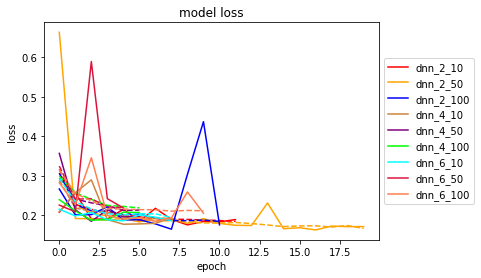

In [81]:
color_list = ['red', 'orange', 'blue', 'peru', 'purple', 'lime', 'cyan', 'crimson', 'coral']
model_list = list(models.keys())
model_colors = {}
for i in range(len(models)):
    model_name = model_list[i]
    model_colors[model_name] = color_list[i]

for model_name in models:
    plt.plot(models[model_name]['history'].history['loss'], color=model_colors[model_name], linestyle='--')
    plt.plot(models[model_name]['history'].history['val_loss'], label=f'{model_name}', color=model_colors[model_name])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('plots/train_comparison.pdf')
plt.show()

## Evaluate the Model

In [82]:
from sklearn import metrics

In [83]:
for model_name in models:
    # ROC curve
    test_prediction = models[model_name]['model'].predict(test_values)
    fpr, tpr, thresholds = metrics.roc_curve(test_classification, test_prediction, sample_weight=test_weights_reweighted)
    roc_auc = metrics.auc(fpr, tpr)
    models[model_name]['roc_auc'] = roc_auc
    
    # evaluate model
    train_loss = models[model_name]['history'].history['loss'][0]
    train_accuracy = models[model_name]['history'].history['binary_accuracy'][0]
    test_loss = models[model_name]['history'].history['val_loss'][0]
    test_accuracy = models[model_name]['history'].history['val_binary_accuracy'][0]
    
    models[model_name]['roc_auc'] = roc_auc
    models[model_name]['train_loss'] = train_loss
    models[model_name]['train_accuracy'] = train_accuracy
    models[model_name]['test_loss'] = test_loss
    models[model_name]['test_accuracy'] = test_accuracy
    print(f'{model_name}: \tROC = {round(roc_auc, 3)}  \ttest_loss = {round(test_loss,8)} \ttest_acc = {round(test_accuracy*100,1)}% \ttest/train_loss = {round(test_loss/train_loss,1)}')

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_2_10: 	ROC = 0.975  	test_loss = 0.20809378 	test_acc = 92.6% 	test/train_loss = 0.7


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_2_50: 	ROC = 0.981  	test_loss = 0.66365135 	test_acc = 74.6% 	test/train_loss = 2.2


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_2_100: 	ROC = 0.98  	test_loss = 0.26698934 	test_acc = 90.3% 	test/train_loss = 0.9


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_4_10: 	ROC = 0.976  	test_loss = 0.20928819 	test_acc = 91.8% 	test/train_loss = 0.7


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_4_50: 	ROC = 0.975  	test_loss = 0.35714213 	test_acc = 86.3% 	test/train_loss = 1.2


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_4_100: 	ROC = 0.976  	test_loss = 0.24006625 	test_acc = 89.9% 	test/train_loss = 0.8


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_6_10: 	ROC = 0.978  	test_loss = 0.2160842 	test_acc = 92.4% 	test/train_loss = 0.7


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_6_50: 	ROC = 0.971  	test_loss = 0.22623171 	test_acc = 91.2% 	test/train_loss = 0.7


/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


dnn_6_100: 	ROC = 0.965  	test_loss = 0.28301673 	test_acc = 92.2% 	test/train_loss = 0.9


In [ ]:
import seaborn as sns

evaluation_full = {'roc_auc': [],'n_layers': [], 'n_nodes': [], 'roc_auc': [], 'test_loss': [], 'test_accuracy': [], 'test/train_loss': []}

for model_name in models:
    n_layers = int(model_name.split('_')[1])
    n_nodes = int(model_name.split('_')[2])
    evaluation_full['n_layers'].append(n_layers)
    evaluation_full['n_nodes'].append(n_nodes)
    evaluation_full['roc_auc'].append(models[model_name]['roc_auc'])
    evaluation_full['test_loss'].append(models[model_name]['test_loss'])
    evaluation_full['test_accuracy'].append(models[model_name]['test_accuracy'])
    evaluation_full['test/train_loss'].append(models[model_name]['test_loss']/models[model_name]['train_loss'])

evaluation_full_df = pd.DataFrame(evaluation_full)

for eval in ['roc_auc', 'test_loss', 'test_accuracy', 'test/train_loss']:
    pivot = evaluation_full_df.pivot(index='n_layers', columns='n_nodes', values=eval)
    sns.heatmap(pivot, cbar_kws={'label': eval}, cmap='crest')
    plt.title(eval)
    
    eval_string = eval.replace('/', '_')
    layers_string = str(list(set(evaluation_full_df['n_layers']))).replace(' ', '')
    nodes_string = str(list(set(evaluation_full_df['n_nodes']))).replace(' ', '')
    plt.savefig(f'plots/evaluate_{eval_string}_layers_{layers_string}_nodes_{nodes_string}.pdf')
    plt.show()

In [88]:
print(evaluation_full)
for (key, value) in evaluation_full.items():
    print(key)
    print(value)

{'roc_auc': [0.9751953679238319, 0.9805248494521376, 0.9796108680991524, 0.9764584179050277, 0.9753572834510319, 0.9756046699637893, 0.9779600970431843, 0.9714330458343654, 0.9645687033745871], 'n_layers': [2, 2, 2, 4, 4, 4, 6, 6, 6], 'n_nodes': [10, 50, 100, 10, 50, 100, 10, 50, 100], 'test_loss': [0.20809377847538515, 0.6636513480482509, 0.26698934235001887, 0.20928819017982297, 0.35714212970084036, 0.24006624833295903, 0.21608420214245713, 0.22623171178481052, 0.2830167299482538], 'test_accuracy': [0.9262790679931641, 0.7459542751312256, 0.9028369784355164, 0.918135941028595, 0.8630046844482422, 0.898649275302887, 0.9240110516548157, 0.9115179181098938, 0.921966552734375], 'test/train_loss': [0.6572886211635621, 2.1607508055338744, 0.8690813709422708, 0.7255571784464743, 1.2122050445950798, 0.8011670455853026, 0.7337514514788485, 0.6962734691638942, 0.897003959961543]}
roc_auc
[0.9751953679238319, 0.9805248494521376, 0.9796108680991524, 0.9764584179050277, 0.9753572834510319, 0.9756

In [92]:
model_name = 'model_627_628478'
n_layers = int(model_name.split('_')[1])
print(model_name.split('_'))
print(n_layers)

['model', '627', '628478']
627


In [96]:
evaluation_full_df = pd.DataFrame(evaluation_full)
print(evaluation_full_df)

    roc_auc  n_layers  n_nodes  test_loss  test_accuracy  test/train_loss
0  0.975195         2       10   0.208094       0.926279         0.657289
1  0.980525         2       50   0.663651       0.745954         2.160751
2  0.979611         2      100   0.266989       0.902837         0.869081
3  0.976458         4       10   0.209288       0.918136         0.725557
4  0.975357         4       50   0.357142       0.863005         1.212205
5  0.975605         4      100   0.240066       0.898649         0.801167
6  0.977960         6       10   0.216084       0.924011         0.733751
7  0.971433         6       50   0.226232       0.911518         0.696273
8  0.964569         6      100   0.283017       0.921967         0.897004


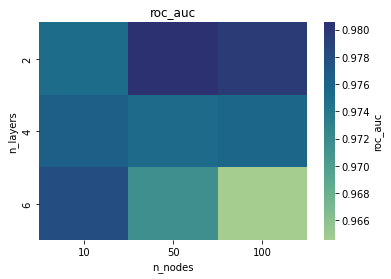

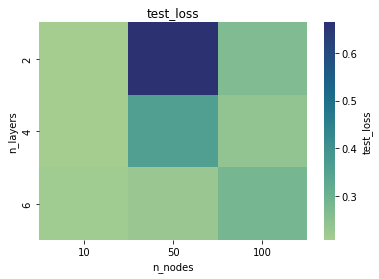

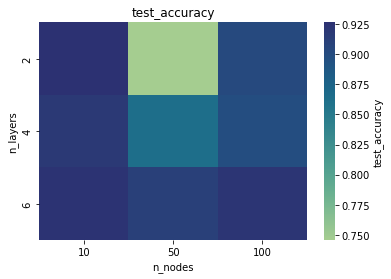

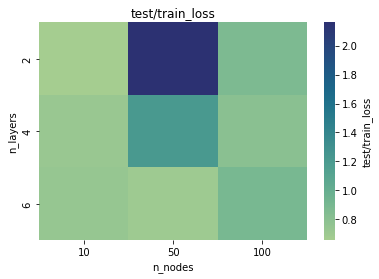

In [94]:
evaluation_full_df = pd.DataFrame(evaluation_full)

for eval in ['roc_auc', 'test_loss', 'test_accuracy', 'test/train_loss']:
    pivot = evaluation_full_df.pivot(index='n_layers', columns='n_nodes', values=eval)
    sns.heatmap(pivot, cbar_kws={'label': eval}, cmap='crest')
    plt.title(eval)
    
    eval_string = eval.replace('/', '_')
    layers_string = str(list(set(evaluation_full_df['n_layers']))).replace(' ', '')
    nodes_string = str(list(set(evaluation_full_df['n_nodes']))).replace(' ', '')
    plt.savefig(f'plots/evaluate_{eval_string}_layers_{layers_string}_nodes_{nodes_string}.pdf')
    plt.show()

## Apply Model

In [98]:
for sample in sample_list_signal + sample_list_background:
    print(f'Apply Model for {sample}')
    # Get the values to apply the model
    data_frame_values = data_frames[sample][training_variables]
    for model in models:
        prediction = models[model]['model'].predict(data_frame_values)
    
        # Convert prediction to array
        prediction = [element[0] for element in prediction]
    
        # Add the prediction for each sample
        data_frames[sample][f'{model}_prediction'] = prediction

Apply Model for ggH125_ZZ4lep
Apply Model for VBFH125_ZZ4lep
Apply Model for WH125_ZZ4lep
Apply Model for ZH125_ZZ4lep
Apply Model for llll
Apply Model for Zee
Apply Model for Zmumu
Apply Model for ttbar_lep


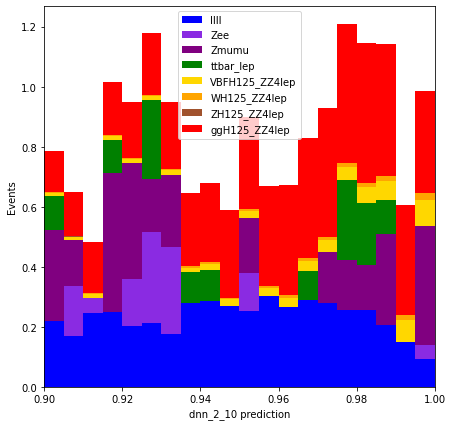

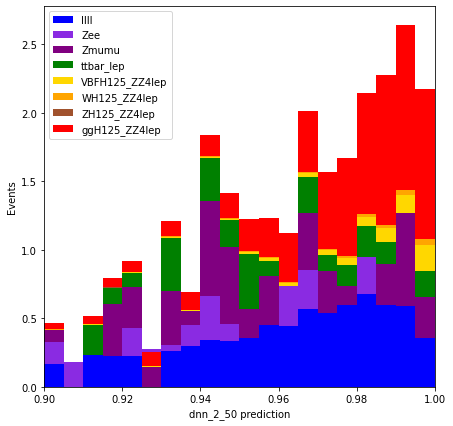

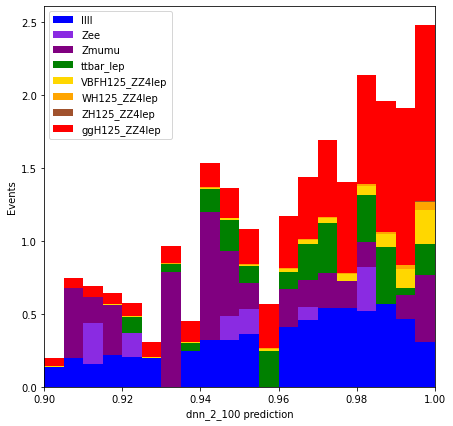

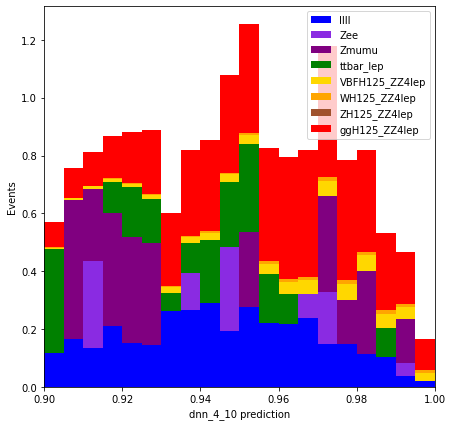

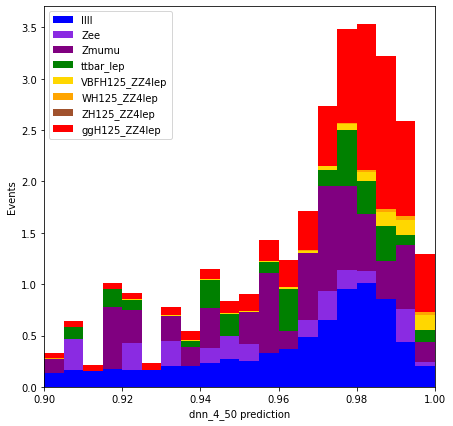

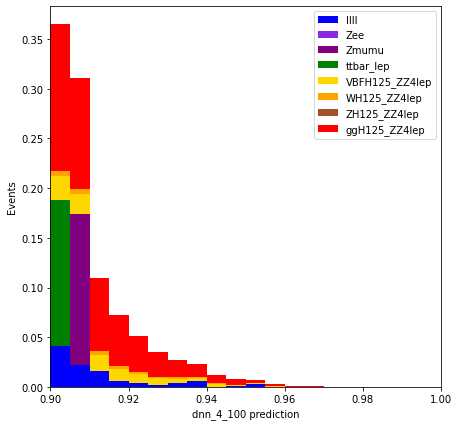

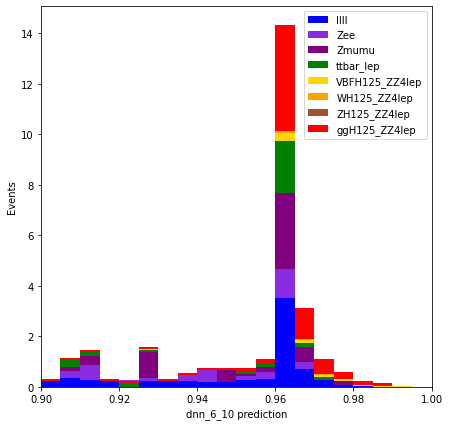

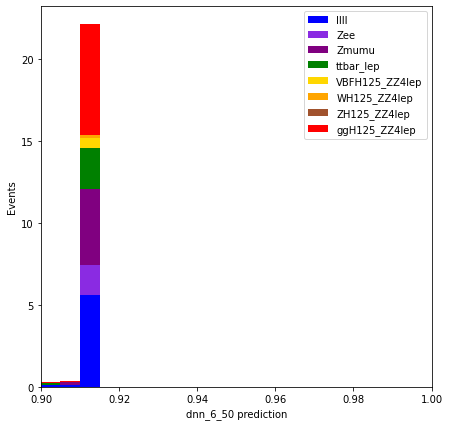

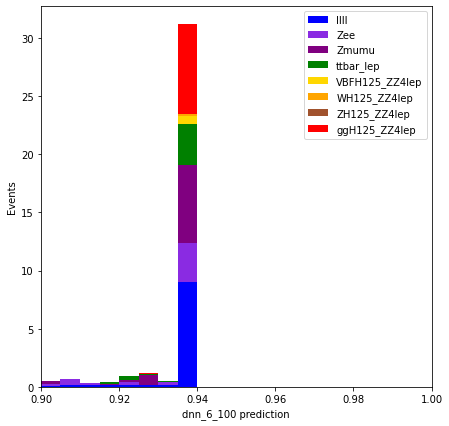

In [99]:
# Investigate DDN Prediction
for model in models:
    var_dnn = {'variable': f'{model}_prediction',
               'binning': np.linspace(0.9, 1, 21),
               'xlabel': f'{model} prediction'}

    common.plot_hist_sum(var_dnn, data_frames)

In [99]:
# Create a copy of the data frame
apply_dnn_data_frames = data_frames.copy()

# Apply the DNN value
for sample in sample_list_signal + sample_list_background:
    print(sample)
    pass_dnn = apply_dnn_data_frames[sample]['dnn_prediction'] > 0.5
    apply_dnn_data_frames[sample] = apply_dnn_data_frames[sample][pass_dnn]
    print(len(apply_dnn_data_frames[sample])/len(data_frames[sample]))

ggH125_ZZ4lep
0.0
VBFH125_ZZ4lep
0.0
WH125_ZZ4lep
0.0
ZH125_ZZ4lep
0.0
llll
0.0
Zee
0.0
Zmumu
0.0
ttbar_lep
0.0


In [ ]:
# leading lepton pt
var_lep1_pt = {'variable': 'lep_m_llll',
               'binning': np.linspace(0, 200, 40),
               'xlabel': '$m_{llll}$ [GeV]'}

common.plot_hist_sum(var_lep1_pt, apply_dnn_data_frames)

# Validation